### Dependency

In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [34]:
torch.cuda.is_available()

False

In [35]:
# Read the binary raw data into a numpy array
np_array = np.fromfile('./Berea_2d25um_grayscale_filtered.raw', dtype=np.uint8, count=100000000)

X = np_array.reshape(100, 100, 100, 100)
X.shape

(100, 100, 100, 100)

In [36]:
y = np.random.uniform(low=0.05, high=.35, size=X.shape[0]) # generating porosity values

In [37]:
# Perform train-test-validation split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=27)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.15, random_state=27)

In [38]:
class Custom3dDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).unsqueeze(1).float()
        self.y = torch.from_numpy(y).float()

        # Check if GPU is available and move tensors to GPU
        if torch.cuda.is_available():
            self.X = self.X.cuda()
            self.y = self.y.cuda()

        # Custom normalization
        self.X = self.normalize(self.X)

    def normalize(self, x):
        x_normalized = (x - x.min())/(x.max() - x.min())
        return x_normalized

    def __getitem__(self, index):
        x = self.X[index]
        return x, self.y[index]

    def __len__(self):
        return len(self.X)

In [39]:
# Create custom datasets for training, testing, and validation set
train_dataset = Custom3dDataset(X_train, y_train)
test_dataset = Custom3dDataset(X_test, y_test)
valid_dataset = Custom3dDataset(X_valid, y_valid)

In [40]:
# Set random seed for reproducibility
torch.manual_seed(27)

# Create DataLoaders for training, testing, and validation set
batch_size = 10
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

# for GPU support
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
# valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

### How convolution output is passed into the fully connected layer

In [47]:
conv1 = nn.Conv3d(1, 16, kernel_size=5, stride=1, padding=1)
pool1 = nn.MaxPool3d(kernel_size=5, stride=3)
conv2 = nn.Conv3d(16, 32, kernel_size=5, stride=1, padding=1)
pool2 = nn.MaxPool3d(kernel_size=5, stride=3)

for X_train, y_train in train_loader:
    break
    
a = F.relu(conv1(X_train))
a = pool1(a)
a = F.relu(conv2(a))
a = pool2(a)
print(a.shape)

torch.Size([10, 32, 9, 9, 9])


In [45]:
32*9*9*9

23328

In [46]:
x = x.view(x.size(0), -1)
x.shape[1]

23328

### Model Class

In [49]:
class CNN3dModel(nn.Module):
    def __init__(self):
        super().__init__()

        # Convolutional layers
        self.conv1 = nn.Conv3d(1, 16, kernel_size=5, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool3d(kernel_size=5, stride=3)

        self.conv2 = nn.Conv3d(16, 32, kernel_size=5, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool3d(kernel_size=5, stride=3)

        # Fully connected layers
        self.fc1 = nn.Linear(a.shape[1], 128) # need to change according to convolution and pooling layers
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 84)
        self.relu4 = nn.ReLU()
        self.fc3 = nn.Linear(84, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = x.view(x.size(0), -1)  # Flatten the tensor

        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        x = self.relu4(x)
        x = self.fc3(x)

        return x.squeeze(1)  # Remove the extra dimension from the output

In [11]:
# Create an instance of the CNN model
model = CNN3dModel()
model
# gpu support
# gpumodel = model.cuda()

CNN3dModel(
  (conv1): Conv3d(1, 16, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(1, 1, 1))
  (relu1): ReLU()
  (pool1): MaxPool3d(kernel_size=5, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv3d(16, 32, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(1, 1, 1))
  (relu2): ReLU()
  (pool2): MaxPool3d(kernel_size=5, stride=3, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=23328, out_features=128, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=128, out_features=84, bias=True)
  (relu4): ReLU()
  (fc3): Linear(in_features=84, out_features=1, bias=True)
)

### Total learnable parameters

In [26]:
def count_parameters(Model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>8}')
    print(f'________\n{sum(params):>8}')
    
count_parameters(CNN3dModel)

    2000
      16
   64000
      32
 2985984
     128
   10752
      84
      84
       1
________
 3063081


### Early stopping for overfitting issue

In [14]:
class EarlyStopper:
    def __init__(self, patience=8, min_delta=0):
        """
        min_delta: Minimum change in the monitored quantity to qualify as an improvement, 
        i.e. an absolute change of less than min_delta, will count as no improvement.
        patience: Number of epochs with no improvement after which training will be stopped.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [15]:
# function to convert seconds to into hours, minutes and seconds
# this function is used to measure the time taking by the models
def convert(seconds):
    seconds = seconds % (24 * 3600)
    hour = seconds // 3600
    seconds %= 3600
    minutes = seconds // 60
    seconds %= 60
    return "%d:%02d:%02d" % (hour, minutes, seconds)

### Loss function and optimizer

In [16]:
criterion = nn.MSELoss()  # we'll convert this to RMSE later
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Train the model

In [17]:
import time

start = time.time()

early_stopper = EarlyStopper(patience=10, min_delta=10)
epochs = 15
train_losses = []
valid_losses = []

for i in range(epochs):

    # run the training batches
    for b, (X_tr, y_tr) in enumerate(train_loader):
        b+=1

        # apply the model
        y_pred = model(X_tr)
        train_loss = torch.sqrt(criterion(y_pred, y_tr)) # RMSE of training data

        # Update parameters
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        # printing interim results
        # if b%10 == 0:
        print(f'epoch: {i:2}\t batch: {b:4}\t Training_loss: {train_loss.item():10.8f}')
          
    train_losses.append(train_loss) # tracking training losses over the epochs

    # run the validation batches
    with torch.no_grad():
        for b, (X_val, y_val) in enumerate(valid_loader):
            # apply the model
            y_valid_pred = model(X_val)
                                
    valid_loss = torch.sqrt(criterion(y_valid_pred, y_val)) # RMSE calculation of validation data
    valid_losses.append(valid_loss)
    
    if early_stopper.early_stop(valid_loss):             
        epochs = i
        print("We are at epoch:", i)
        break

end = time.time()

print('training_duration:', convert(end-start), 'h:m:s') # print total training time

epoch:  0	 batch:    1	 Training_loss: 0.26630822
epoch:  0	 batch:    2	 Training_loss: 1.42537570
epoch:  0	 batch:    3	 Training_loss: 0.37064508
epoch:  0	 batch:    4	 Training_loss: 0.22174278
epoch:  0	 batch:    5	 Training_loss: 0.20247668
epoch:  0	 batch:    6	 Training_loss: 0.22106895
epoch:  0	 batch:    7	 Training_loss: 0.22510499
epoch:  0	 batch:    8	 Training_loss: 0.10905659
epoch:  1	 batch:    1	 Training_loss: 0.15500285
epoch:  1	 batch:    2	 Training_loss: 0.08733860
epoch:  1	 batch:    3	 Training_loss: 0.14280494
epoch:  1	 batch:    4	 Training_loss: 0.11958210
epoch:  1	 batch:    5	 Training_loss: 0.12060394
epoch:  1	 batch:    6	 Training_loss: 0.12763193
epoch:  1	 batch:    7	 Training_loss: 0.12356017
epoch:  1	 batch:    8	 Training_loss: 0.13679804
epoch:  2	 batch:    1	 Training_loss: 0.11789890
epoch:  2	 batch:    2	 Training_loss: 0.12239305
epoch:  2	 batch:    3	 Training_loss: 0.10531194
epoch:  2	 batch:    4	 Training_loss: 0.10637569


### Training and validation losses visualization

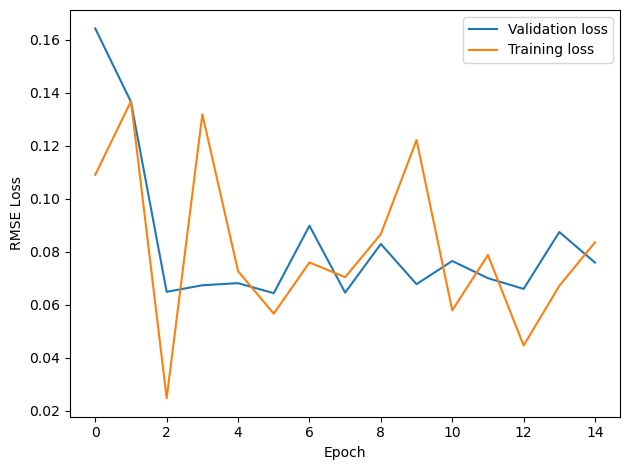

In [18]:
new_train_losses = []
new_valid_losses = []
for i in range(len(train_losses)):
    losses_1 = train_losses[i].detach().numpy()
    new_train_losses.append(losses_1)

for i in range(len(valid_losses)):
    losses_2 = valid_losses[i].detach().numpy()
    new_valid_losses.append(losses_2)

plt.plot(range(epochs), new_valid_losses, label='Validation loss')
plt.plot(range(epochs), new_train_losses, label='Training loss')
plt.ylabel('RMSE Loss')
plt.xlabel('Epoch');
plt.legend(loc='upper right')

plt.tight_layout()
# plt.savefig("./output/cnn/training_loss_plot_cnn.png", dpi=300)

### Evaluation of this model in training, testing dataset

In [19]:
# Extract the data all at once for training and testing set, not in batches
train_load_all = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=True)
test_load_all = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

In [20]:
with torch.no_grad():
    for X_train, y_train in train_load_all:
        pred_1 = model(X_train)
    for X_test, y_test in test_load_all:
        pred_2 = model(X_test)

### Saving training and testing data with their predicted values in a excel file

In [21]:
import os

# Create the output directory if it doesn't exist
output_dir = "./output/cnn"
os.makedirs(output_dir, exist_ok=True)

# Create the dataframes
a = pd.DataFrame(np.stack([y_train, pred_1], axis=1), columns=['y_train', 'y_train_pred'])
b = pd.DataFrame(np.stack([y_test, pred_2], axis=1), columns=['y_test', 'y_test_pred'])

# Save the dataframes to an Excel file
output_path = os.path.join(output_dir, "predicted_cnn_model.xlsx")
with pd.ExcelWriter(output_path) as writer:
    a.to_excel(writer, sheet_name="training", index=True)
    b.to_excel(writer, sheet_name="testing", index=True)

### Performance metrics for training and testing set

In [22]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import max_error

train_r2 = r2_score(y_train,pred_1)
train_mae = mean_absolute_error(y_train, pred_1)
train_mse = mean_squared_error(y_train, pred_1)
train_mape = mean_absolute_percentage_error(y_train, pred_1)
train_maxE = max_error(y_train, pred_1)
train_minE = min(abs(y_train - pred_1))

test_r2 = r2_score(y_test, pred_2)
test_mae = mean_absolute_error(y_test, pred_2)
test_mse = mean_squared_error(y_test, pred_2)
test_mape = mean_absolute_percentage_error(y_test, pred_2)
test_maxE = max_error(y_test, pred_2)
test_minE = min(abs(y_test - pred_2))

metrics = {
'performance_metrics': ['R2', 'MAE', 'MSE', 'MAPE', 'maxE', 'minE'],
'training': [train_r2, train_mae, train_mse, train_mape, train_maxE, train_minE],
'testing': [test_r2, test_mae, test_mse, test_mape, test_maxE, test_minE]
}

performance_metrics = pd.DataFrame(metrics)
performance = performance_metrics.transpose()
performance.to_csv('./output/cnn/performance_cnn.csv')
performance

,0,1,2,3,4,5
performance_metrics,R2,MAE,MSE,MAPE,maxE,minE
training,-0.014546,0.073694,0.007154,0.497057,0.156373,tensor(0.0012)
testing,-0.076119,0.087227,0.008797,0.636636,0.161243,tensor(0.0316)


### Save the trained model to a file

In [23]:
# Make sure to save the model only after the training has happened!
if len(train_losses) == epochs:
    torch.save(model.state_dict(), './output/cnn/trained_model_cnn.pt')
else:
    print('Model has not been trained. Consider loading a trained model instead.')

### Load a new model

In [24]:
model2 = CNN3dModel()

model2.load_state_dict(torch.load('./output/cnn/trained_model_cnn.pt'))
model2.eval() # be sure to run this step!

CNN3dModel(
  (conv1): Conv3d(1, 16, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(1, 1, 1))
  (relu1): ReLU()
  (pool1): MaxPool3d(kernel_size=5, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv3d(16, 32, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(1, 1, 1))
  (relu2): ReLU()
  (pool2): MaxPool3d(kernel_size=5, stride=3, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=23328, out_features=128, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=128, out_features=84, bias=True)
  (relu4): ReLU()
  (fc3): Linear(in_features=84, out_features=1, bias=True)
)